In [2]:
!pip install beautifulsoup4
!pip install lxml
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9880bd3_2         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                       

### Extracting table of postal codes of Canada from wikipedia via scraping  
- Request the wikipedia page for postal code canada data 
- Extract table and convert in to df
- Rename Postal code and neighborhood column lables 

In [6]:
from IPython.display import display_html
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'html')
table = str(soup.table)
#display_html(table, raw = True)
dataframe = pd.read_html(table)
df = dataframe[0]
df.rename(columns= {'Postal Code': 'PostalCode', 'Neighbourhood': 'Neighborhood'}, inplace = True)
df.shape

(180, 3)

###  Preprocessing and Cleaning the data in DF 
- Drop rows that have Borough = Nont assigned
- combine the neighbourhood with same postalcode
- add borough value to neighbor for not assigned neighbour


In [8]:
df
filter_df = df[df['Borough'] != "Not assigned"]
# Combining the neighbourhoods with same Postalcode
df2 = filter_df.groupby(['PostalCode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

# add the not assigned neighbour from Borough
df2['Neighborhood'] = np.where(df2['Neighborhood'] == 'Not assigned', df2['Borough'], df2['Neighborhood'])
df2.head(10)

PostalCode           Borough                                 Neighborhood
0        M3A        North York                                    Parkwoods
1        M4A        North York                             Victoria Village
2        M5A  Downtown Toronto                    Regent Park, Harbourfront
3        M6A        North York             Lawrence Manor, Lawrence Heights
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
5        M9A         Etobicoke      Islington Avenue, Humber Valley Village
6        M1B       Scarborough                               Malvern, Rouge
7        M3B        North York                                    Don Mills
8        M4B         East York              Parkview Hill, Woodbine Gardens
9        M5B  Downtown Toronto                     Garden District, Ryerson

In [9]:
# find Shape of the processed DF
df2.shape

(103, 3)

### Import and extract Lat and log of the neighborhoods in region
- change the postal code column name 

In [12]:
lat_log_df = pd.read_csv('https://cocl.us/Geospatial_data')
lat_log_df.rename(columns= {'Postal Code': 'PostalCode'}, inplace = True )
lat_log_df.head(10)

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476
5        M1J  43.744734 -79.239476
6        M1K  43.727929 -79.262029
7        M1L  43.711112 -79.284577
8        M1M  43.716316 -79.239476
9        M1N  43.692657 -79.264848

### Merge the two dataframes based on PostalCode and integrate the the lag and log 
- Generate new dataframe after merging the two dataframes based on postal code

In [15]:
df3 = pd.merge (df2, lat_log_df, on = "PostalCode")
df3.head(10)

PostalCode           Borough                                 Neighborhood  \
0        M3A        North York                                    Parkwoods   
1        M4A        North York                             Victoria Village   
2        M5A  Downtown Toronto                    Regent Park, Harbourfront   
3        M6A        North York             Lawrence Manor, Lawrence Heights   
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   
5        M9A         Etobicoke      Islington Avenue, Humber Valley Village   
6        M1B       Scarborough                               Malvern, Rouge   
7        M3B        North York                                    Don Mills   
8        M4B         East York              Parkview Hill, Woodbine Gardens   
9        M5B  Downtown Toronto                     Garden District, Ryerson   

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494  
5  43.667856 -79.532242  
6  43.806686 -79.194353  
7  43.745906 -79.352188  
8  43.706397 -79.309937  
9  43.657162 -79.378937

### Clustering and visualization of the neighborhood of the Borough "Toronto"
- Extract rows that contains Borough "Toronto"
- we use strg contains string Toronto

In [34]:
toronto_df = df3[df3['Borough'].str.contains('Toronto', regex = False)]
toronto_df.head(10)

PostalCode           Borough                                 Neighborhood  \
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   
9         M5B  Downtown Toronto                     Garden District, Ryerson   
15        M5C  Downtown Toronto                               St. James Town   
19        M4E      East Toronto                                  The Beaches   
20        M5E  Downtown Toronto                                  Berczy Park   
24        M5G  Downtown Toronto                           Central Bay Street   
25        M6G  Downtown Toronto                                     Christie   
30        M5H  Downtown Toronto                     Richmond, Adelaide, King   
31        M6H      West Toronto                 Dufferin, Dovercourt Village   

     Latitude  Longitude  
2   43.654260 -79.360636  
4   43.662301 -79.389494  
9   43.657162 -79.378937  
15  43.651494 -79.375418  
19  43.676357 -79.293031  
20  43.644771 -79.373306  
24  43.657952 -79.387383  
25  43.669542 -79.422564  
30  43.650571 -79.384568  
31  43.669005 -79.442259

### Visualize the Neighborhoods using the Folium pickage for randering spatial data 
- 

In [23]:
toronto_map  = folium.Map(location = [43.651070,-79.347015],zoom_start=10)
for lat, log, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'],toronto_df['Borough'],toronto_df['Neighborhood'] ):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,log],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(toronto_map)
toronto_map

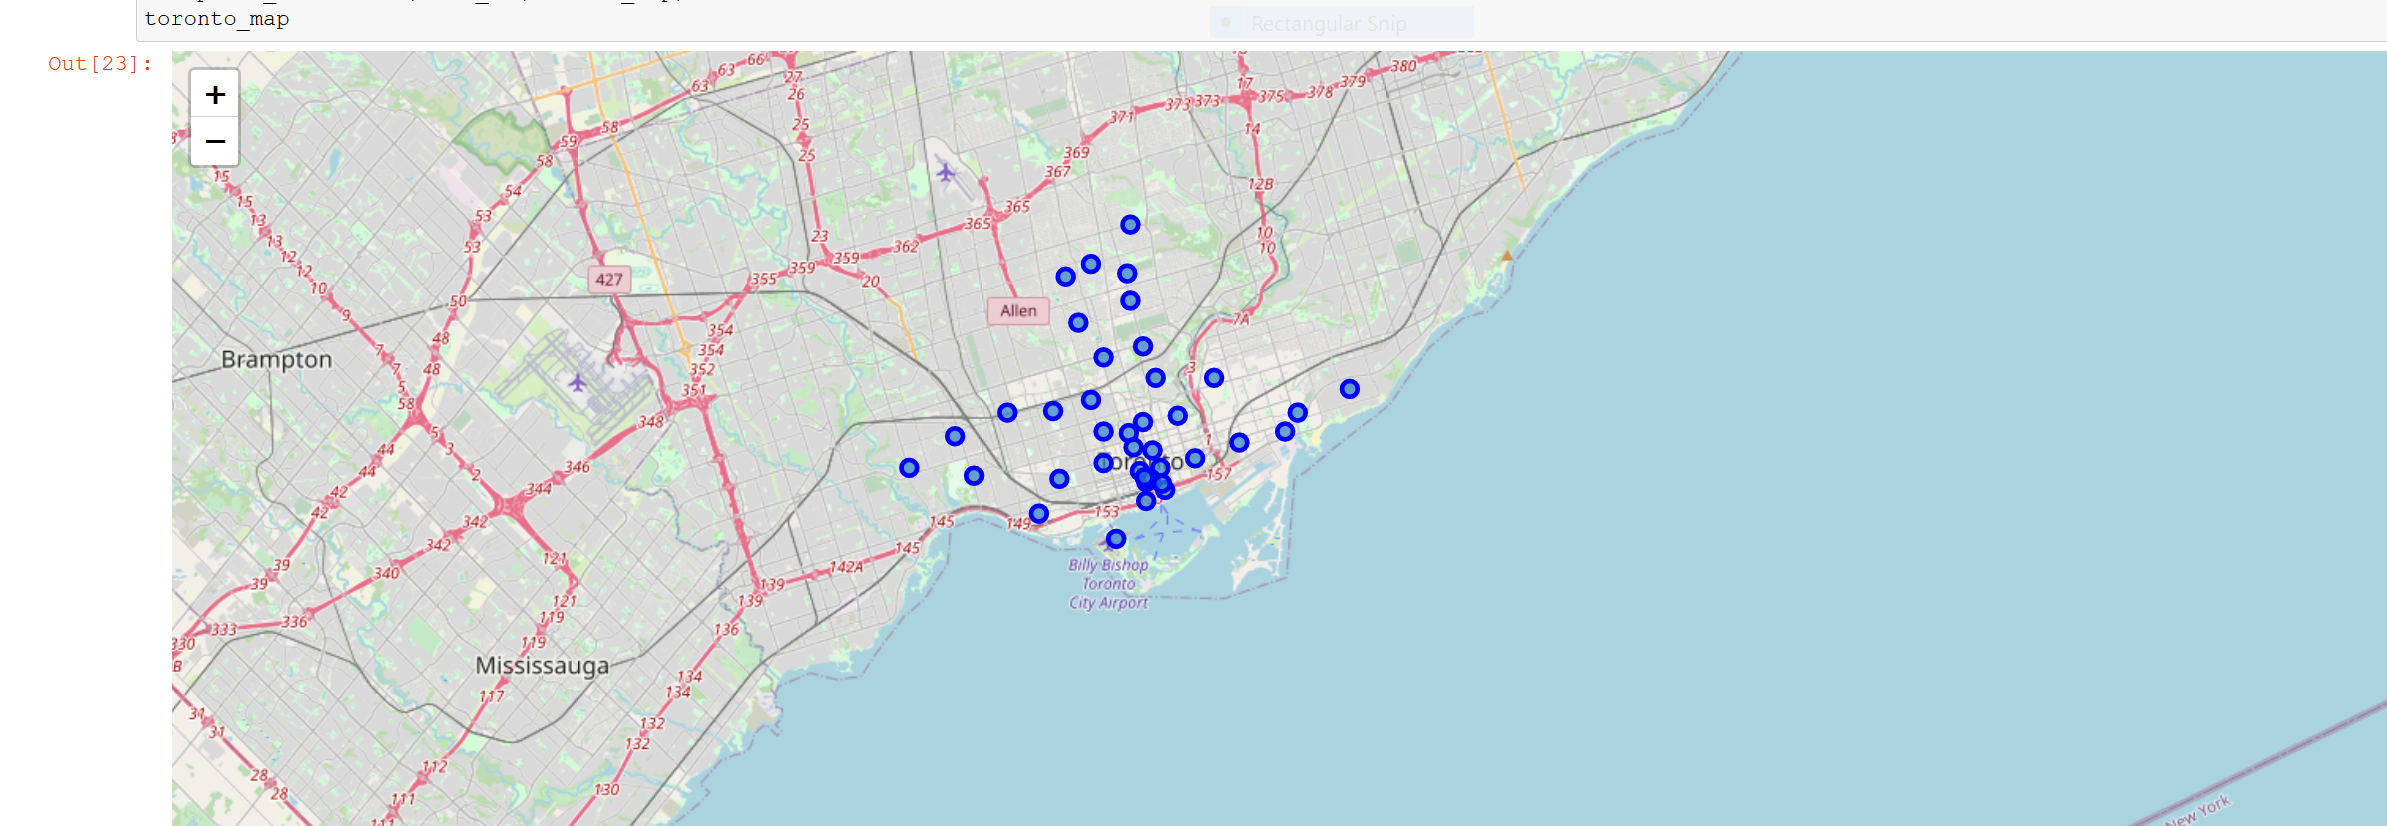

### Create cluster for neighborhood 
- We use K-mean clustering 


In [35]:
clusters = 5
toronto_clusters = toronto_df.drop(['PostalCode','Borough','Neighborhood'],1)
k_means = KMeans(n_clusters = clusters, random_state = 0).fit (toronto_clusters)
k_means.labels_


array([0, 0, 0, 0, 4, 0, 0, 3, 0, 1, 0, 3, 4, 0, 3, 4, 0, 4, 2, 2, 2, 2,
       1, 2, 3, 1, 2, 3, 1, 2, 3, 2, 0, 0, 0, 0, 0, 0, 4], dtype=int32)

### Insert labels in the toronto_df

In [36]:
toronto_df.insert(0, 'ClusterLabels', k_means.labels_)
toronto_df.head(10)

ClusterLabels PostalCode           Borough  \
2               0        M5A  Downtown Toronto   
4               0        M7A  Downtown Toronto   
9               0        M5B  Downtown Toronto   
15              0        M5C  Downtown Toronto   
19              4        M4E      East Toronto   
20              0        M5E  Downtown Toronto   
24              0        M5G  Downtown Toronto   
25              3        M6G  Downtown Toronto   
30              0        M5H  Downtown Toronto   
31              1        M6H      West Toronto   

                                   Neighborhood   Latitude  Longitude  
2                     Regent Park, Harbourfront  43.654260 -79.360636  
4   Queen's Park, Ontario Provincial Government  43.662301 -79.389494  
9                      Garden District, Ryerson  43.657162 -79.378937  
15                               St. James Town  43.651494 -79.375418  
19                                  The Beaches  43.676357 -79.293031  
20                                  Berczy Park  43.644771 -79.373306  
24                           Central Bay Street  43.657952 -79.387383  
25                                     Christie  43.669542 -79.422564  
30                     Richmond, Adelaide, King  43.650571 -79.384568  
31                 Dufferin, Dovercourt Village  43.669005 -79.442259

### visualize the clusters based on created clusterLables 

In [42]:
neighbor_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighborhood'], toronto_df['ClusterLabels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(neighbor_clusters)
       
neighbor_clusters

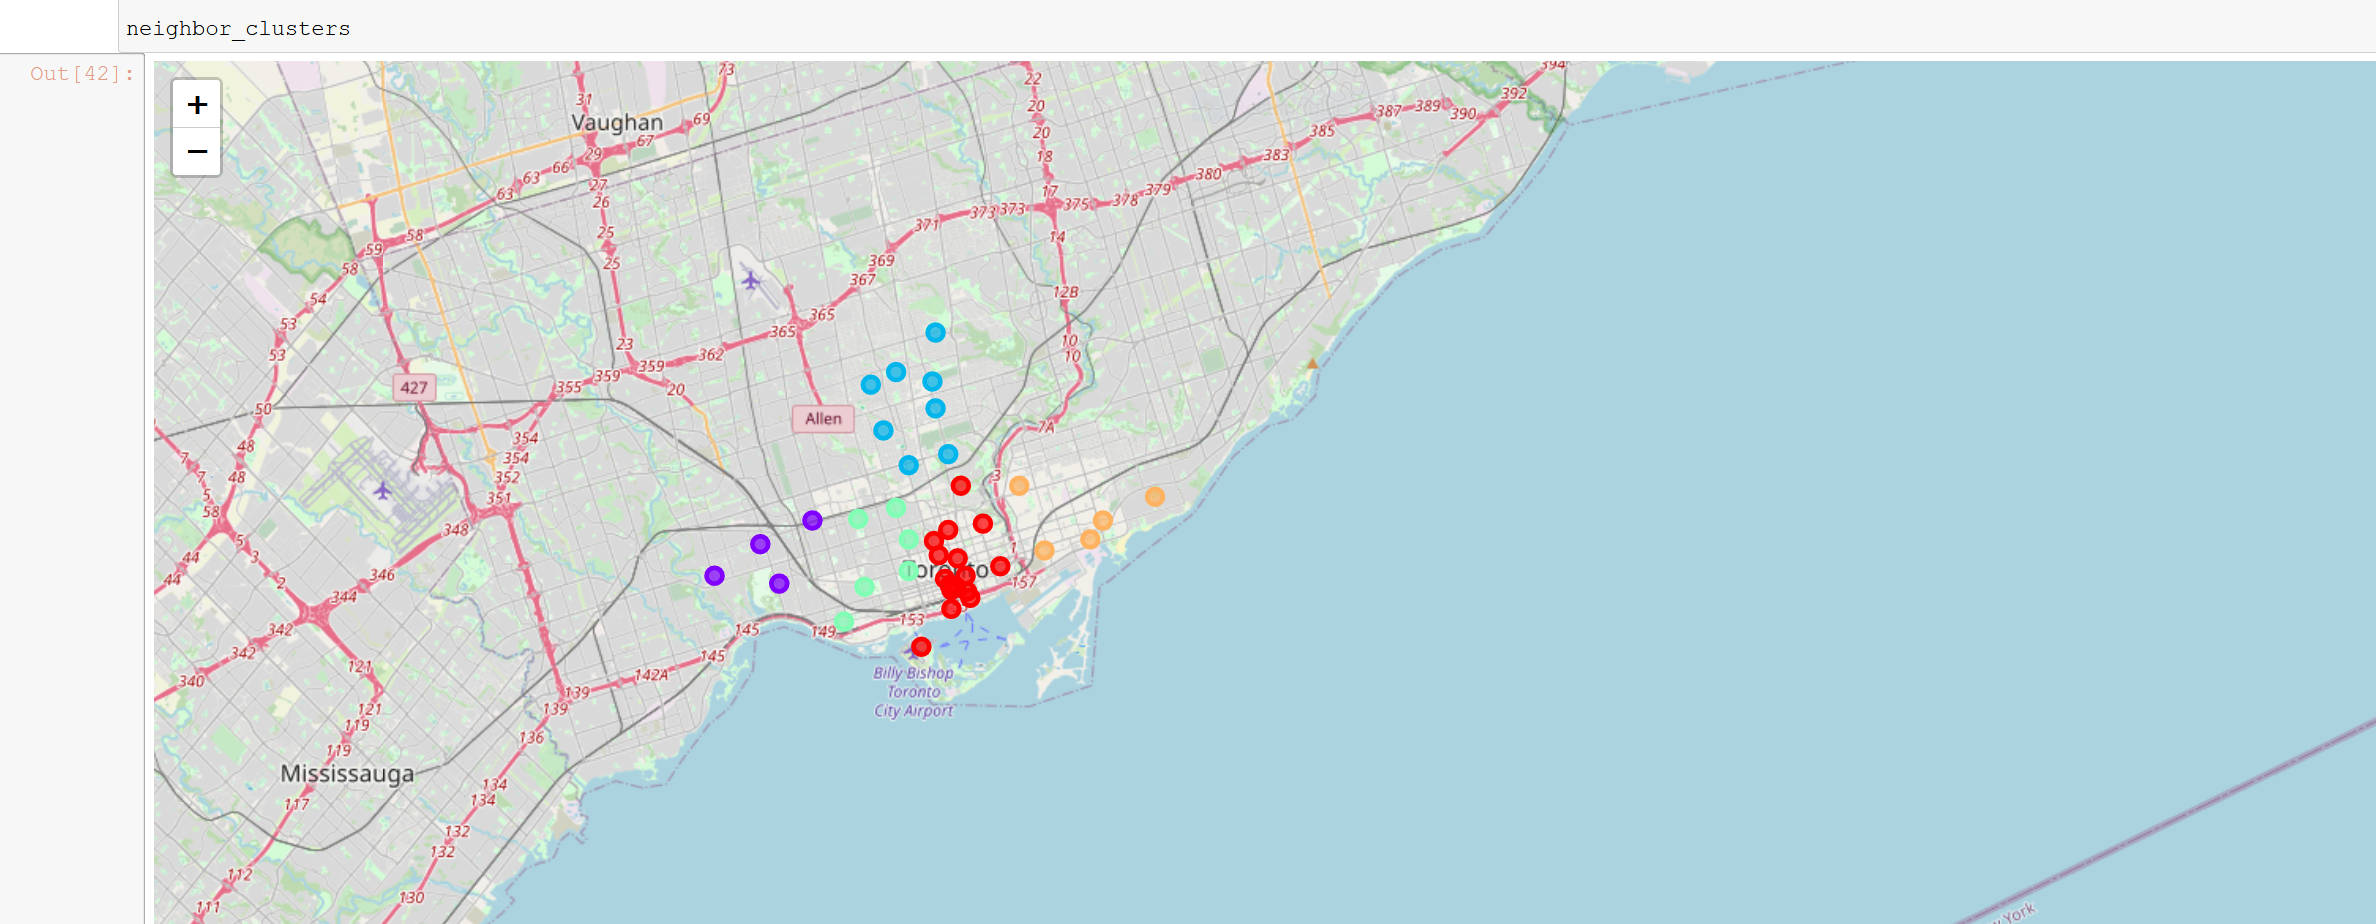